# Readme

To run this Notebook you need to edit the .env file with your AWS credentials to access the database OR you can run the Notebook on the AWS Sagemaker Studio instance

In [1]:
# Comment this cell if you run the notebook on Sagemaker Studio 

import os
from dotenv import load_dotenv
import boto3

key_id = os.environ.get('AWS_ACCESS_KEY_ID', None)
secret_key = os.environ.get('AWS_SECRET_ACCESS_KEY', None)
s3 = boto3.resource('s3',
        aws_access_key_id=key_id,
        aws_secret_access_key=secret_key)

print('You are logged in!')

You are logged in!


In [2]:
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
from tqdm import tqdm

s3 = boto3.resource('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

In [4]:
tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [5]:
variables = wr.s3.read_parquet('s3://icusics-db/d_variables/d_variables.parquet')
patients = wr.s3.read_parquet('s3://icusics-db/patients/patients.parquet')
diagnoses = wr.s3.read_parquet('s3://icusics-db/diagnoses/diagnoses_h4.parquet')

In [83]:
creat_idx = [
    1020000600,2020000600,3020000600,
    4020000600,5020000600,6020000600
]

creatinine = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(creat_idx)]
    creatinine.append(ith)
    
creatinine = pd.concat(creatinine)
creatinine

100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


,a_patientid,a_variableid,time,value
189,1001170,1020000600,2324,1.33
190,1001170,1020000600,3736,1.20
191,1001170,1020000600,8076,0.95
192,1001170,1020000600,9485,0.85
193,1001170,1020000600,10952,0.92
...,...,...,...,...
744038,6986768,6020000600,1393,1.08
744157,6995665,6020000600,-251,0.61
744158,6995665,6020000600,217,0.61
744159,6995665,6020000600,1032,0.61


In [84]:
## add in the lowest value in the previous 48 hours
cols = {'a_patientid':'a_patientid', 'time':'time_48', 'value':'value_48'}
cr48 = creatinine.loc[:, cols.keys()].rename(columns=cols)

m_48 = creatinine.merge(cr48, how='left', on=['a_patientid'])
m_48 = m_48.query("time_48 < time and time_48 >= time - 2880")
m_48 = m_48.merge(creatinine, how='right', on=creatinine.columns.tolist())
m_48 = m_48.groupby(['a_patientid','a_variableid','time','value']).value_48.min().reset_index()


## add in the lowest value in the previous 7 days
cols = {'a_patientid':'a_patientid', 'time':'time_7', 'value':'value_7'}
cr7 = creatinine.loc[:, cols.keys()].rename(columns=cols)

m_7 = creatinine.merge(cr7, how='left', on=['a_patientid'])
m_7 = m_7.query("time_7 < time and time_7 >= time - 10080")
m_7 = m_7.merge(creatinine, how='right', on=creatinine.columns.tolist())
m_7 = m_7.groupby(['a_patientid','a_variableid','time','value']).value_7.min().reset_index()

kdigo_creatinine = m_48.merge(m_7, how='inner', on=['a_patientid', 'a_variableid', 'time', 'value'])

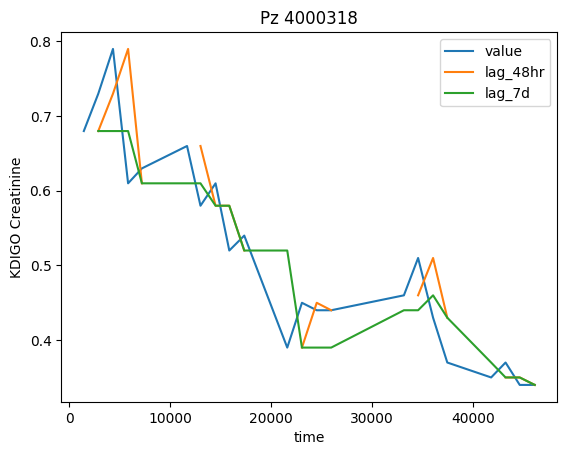

In [85]:
ax = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value', label='value')
_ = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value_48',ax=ax, label='lag_48hr')
_ = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value_7',ax=ax, label='lag_7d')
_ = ax.legend()
_ = ax.set_title('Pz 4000318')
_ = ax.set_ylabel('KDIGO Creatinine')

plt.show()

## Urine Output

In [9]:
uro_idx = [
    1010010000,2010010000,3010010000,
    4010010000,5010010000,6010010000
]

urineOutput = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/observed_numeric/observed_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(uro_idx)]
    urineOutput.append(ith)
    
urineOutput = pd.concat(urineOutput)
urineOutput

100%|██████████| 6/6 [03:04<00:00, 30.71s/it]


,a_patientid,a_variableid,time,value
8,1000091,1010010000,11,180.0
9,1000091,1010010000,34,90.0
10,1000091,1010010000,94,90.0
11,1000091,1010010000,154,200.0
12,1000091,1010010000,274,220.0
...,...,...,...,...
9920959,6995665,6010010000,2513,130.0
9920960,6995665,6010010000,2633,250.0
9920961,6995665,6010010000,2753,150.0
9920962,6995665,6010010000,2873,100.0


In [32]:
def get_lag(df, l, merge_idx=['a_patientid']):
    orig_cols = df.columns.tolist()
    custom_cols = list(map(lambda x: x + '_' + str(l) if x not in merge_idx else x, orig_cols))

    cols = {'time': f'time_{l}', 'value': f'value_{l}'}
    df_l = df.rename(columns=cols)

    m_l = df.merge(df_l, how='left', on=merge_idx)
    lhr = l * 60
    q_str = f"{cols['time']} < time and {cols['time']} > time - {lhr}"
    m_l = m_l.query(q_str)
    m_l = m_l.merge(df, how='right', on=df.columns.tolist())
    
    m_l = m_l.groupby(df.columns.tolist()).agg({cols['value']: np.sum, cols['time']: np.min}).reset_index()
    return m_l

In [37]:
u_patients = urineOutput.a_patientid.unique()

l6 = []
l12 = []
l24 = []

delta = 100
for i in tqdm(range(0, u_patients.shape[0], delta)):
    p_round = u_patients[i:i+delta]
    df = urineOutput[urineOutput.a_patientid.isin(p_round)].loc[:, ['a_patientid', 'time', 'value']]
    i6 = get_lag(df, l=6)
    i12 = get_lag(df, l=12)
    i24 = get_lag(df, l=24)
    l6.append(i6)
    l12.append(i12)
    l24.append(i24)

  0%|          | 0/209 [00:00<?, ?it/s]

100%|██████████| 209/209 [02:34<00:00,  1.36it/s]


In [38]:
uo_l6 = pd.concat(l6, ignore_index=True)
uo_l12 = pd.concat(l12, ignore_index=True)
uo_l24 = pd.concat(l24, ignore_index=True)

uo_l6['uo_tm_6hr'] = (uo_l6.time - uo_l6.time_6) / 60
uo_l12['uo_tm_12hr'] = (uo_l12.time - uo_l12.time_12) / 60
uo_l24['uo_tm_24hr'] = (uo_l24.time - uo_l24.time_24) / 60

uo_l6 = uo_l6.drop(columns='time_6')
uo_l12 = uo_l12.drop(columns='time_12')
uo_l24 = uo_l24.drop(columns='time_24')

uo_m1 = uo_l6.merge(uo_l12, on=['a_patientid','time','value'])
uo_m2 = uo_m1.merge(uo_l24, on=['a_patientid','time','value'])

In [79]:
patients_merge = patients.loc[:, ['a_patientid','weight']]
kdigo_uo = uo_m2.merge(patients_merge, how='inner', on='a_patientid')

## This passage might need investigations
rt_6hr = kdigo_uo.value_6 / kdigo_uo.weight / kdigo_uo.uo_tm_6hr
kdigo_uo['uo_rt_6hr'] = np.where(kdigo_uo.uo_tm_6hr.fillna(0) >= 5, rt_6hr, None)
rt_12hr = kdigo_uo.value_12 / kdigo_uo.weight / kdigo_uo.uo_tm_12hr
kdigo_uo['uo_rt_12hr'] = np.where(kdigo_uo.uo_tm_12hr.fillna(0) >= 11, rt_12hr, None)
rt_24hr = kdigo_uo.value_24 / kdigo_uo.weight / kdigo_uo.uo_tm_24hr
kdigo_uo['uo_rt_24hr'] = np.where(kdigo_uo.uo_tm_24hr.fillna(0) >= 23, rt_24hr, None)

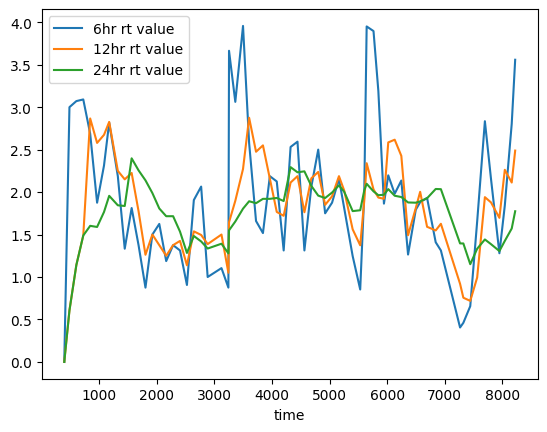

In [42]:
ax = kdigo_uo.query('a_patientid==4000592').plot(x='time', y='uo_rt_6hr', label='6hr rt value') #, ax=ax
_ = kdigo_uo.query('a_patientid==4000592').plot(x='time', y='uo_rt_12hr', ax=ax, label='12hr rt value')
_ = kdigo_uo.query('a_patientid==4000592').plot(x='time', y='uo_rt_24hr', ax=ax, label='24hr rt value')

_ = ax.legend()

plt.show()

## Stages

In [81]:
def creatine_stage(v, v48, v7):
    if (v >= v7*3) or ((v >= 4) and ((v48 <= 3.7) or (v >= 1.5*v7))):
        stage = 3
    elif (v >= v7*2):
        stage = 2
    elif (v >= v48+0.3) or (v >= 1.5*v7):
        stage = 1
    else:
        stage = 0
    return stage

In [86]:
aki_creat = list(map(lambda v,v48,v7: creatine_stage(v, v48, v7), kdigo_creatinine.value, kdigo_creatinine.value_48, kdigo_creatinine.value_7))
kdigo_creatinine['aki_stage_creat'] = aki_creat

In [87]:
cols = {'a_patientid':'a_patientid', 'time':'time', 
        'value':'creat', 'value_48':'creat_48hr', 'value_7':'creat_7days',
       'aki_stage_creat':'aki_stage_creat'}
kdigo_creatinine = kdigo_creatinine.loc[:, cols.keys()].rename(columns=cols)
kdigo_creatinine

,a_patientid,time,creat,creat_48hr,creat_7days,aki_stage_creat
0,1000091,1216,0.86,NaN,NaN,0
1,1000091,2685,0.75,0.86,0.86,0
2,1000091,4185,0.65,0.75,0.75,0
3,1000109,-6115,1.28,NaN,NaN,0
4,1000109,-4870,1.43,1.28,1.28,0
...,...,...,...,...,...,...
126687,6998846,988,0.75,0.82,0.82,0
126688,6999255,134,0.60,NaN,NaN,0
126689,6999255,1444,0.57,0.60,0.60,0
126690,6999255,2874,0.56,0.57,0.57,0


In [88]:
def urineOut_stage(time, uo_tm_6hr, uo_tm_12hr, uo_tm_24hr, uo_rt_6hr, uo_rt_12hr, uo_rt_24hr):
    if (uo_rt_6hr is None):
        stage = None
    elif time < 360:
        stage = 0
    elif ((uo_tm_24hr >= 23) and (uo_rt_24hr < 0.3)) or ((uo_tm_12hr >= 11) and (uo_rt_12hr == 0)):
        stage = 3
    elif (uo_tm_12hr >= 11) and (uo_rt_12hr < 0.5):
        stage = 2
    elif (uo_tm_6hr >= 5) and (uo_rt_6hr  < 0.5):
        stage = 1
    else:
        stage = 0
    return stage

In [89]:
kdigo_uo['aki_stage_uo'] = list(map(lambda t,tm6,tm12,tm24,rt6,rt12,rt24: urineOut_stage(t,tm6,tm12,tm24,rt6,rt12,rt24), 
        kdigo_uo.time, 
        kdigo_uo.uo_tm_6hr.fillna(-1),
        kdigo_uo.uo_tm_12hr.fillna(-1),
        kdigo_uo.uo_tm_24hr.fillna(-1),
        kdigo_uo.uo_rt_6hr.fillna(-1),
        kdigo_uo.uo_rt_12hr.fillna(-1),
        kdigo_uo.uo_rt_24hr.fillna(-1)
        )
)

In [90]:
tm_stg = pd.concat(
    [kdigo_creatinine.loc[:, ['a_patientid','time']],
     kdigo_uo.loc[:, ['a_patientid','time']]
    ], ignore_index=True
)

In [91]:
kdigo_stages = patients.loc[:, ['a_patientid']].merge(tm_stg, how='left', on='a_patientid')
kdigo_stages = kdigo_stages.merge(kdigo_creatinine, how='left', on=['a_patientid','time'])
uo_cols = ['a_patientid','time','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage_uo']
kdigo_stages = kdigo_stages.merge(kdigo_uo.loc[:, uo_cols], how='left', on=['a_patientid','time'])

kdigo_stages['aki_stage'] = list(map(lambda x,y: max(x,y), kdigo_stages.aki_stage_creat.fillna(0).astype(float), kdigo_stages.aki_stage_uo.fillna(0).astype(float)))

kdigo_stages

,a_patientid,time,creat,creat_48hr,creat_7days,aki_stage_creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage_uo,aki_stage
0,1000091,1216,0.86,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
1,1000091,2685,0.75,0.86,0.86,0.0,NaN,NaN,NaN,NaN,0.0
2,1000091,4185,0.65,0.75,0.75,0.0,NaN,NaN,NaN,NaN,0.0
3,1000091,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1000091,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1899784,6999255,3946,NaN,NaN,NaN,NaN,1.754386,1.612903,1.924435,0.0,0.0
1899785,6999255,4306,NaN,NaN,NaN,NaN,None,1.282051,1.694009,0.0,0.0
1899786,6999255,4360,NaN,NaN,NaN,NaN,None,None,1.690141,0.0,0.0
1899787,6999255,4464,NaN,NaN,NaN,NaN,None,None,None,0.0,0.0


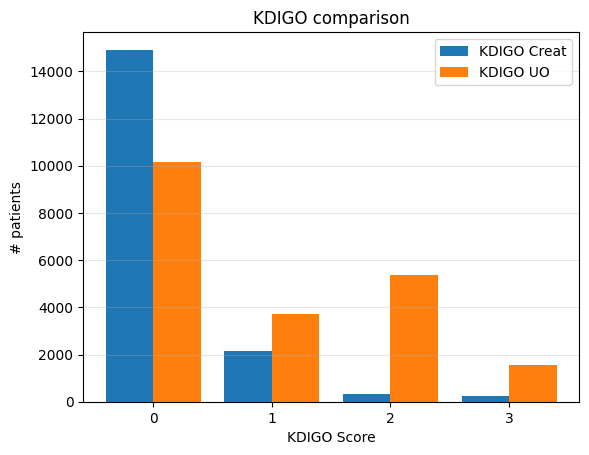

In [92]:
f, ax = plt.subplots()

kdigo_48h = kdigo_stages.query("time<2880")
x = np.arange(0,4)
w = 0.4
_ = ax.bar(x-w/2, kdigo_48h.groupby('a_patientid').aki_stage_creat.max().value_counts().sort_index(), width=w, label='KDIGO Creat')
_ = ax.bar(x+w/2, kdigo_48h.groupby('a_patientid').aki_stage_uo.max().value_counts().sort_index(), width=w, label='KDIGO UO')
_ = ax.legend()
_ = ax.set_title('KDIGO comparison')
_ = ax.grid(axis='y', alpha=0.3)
_ = ax.set_xticks(x)
_ = ax.set_xlabel('KDIGO Score')
_ = ax.set_ylabel('# patients')

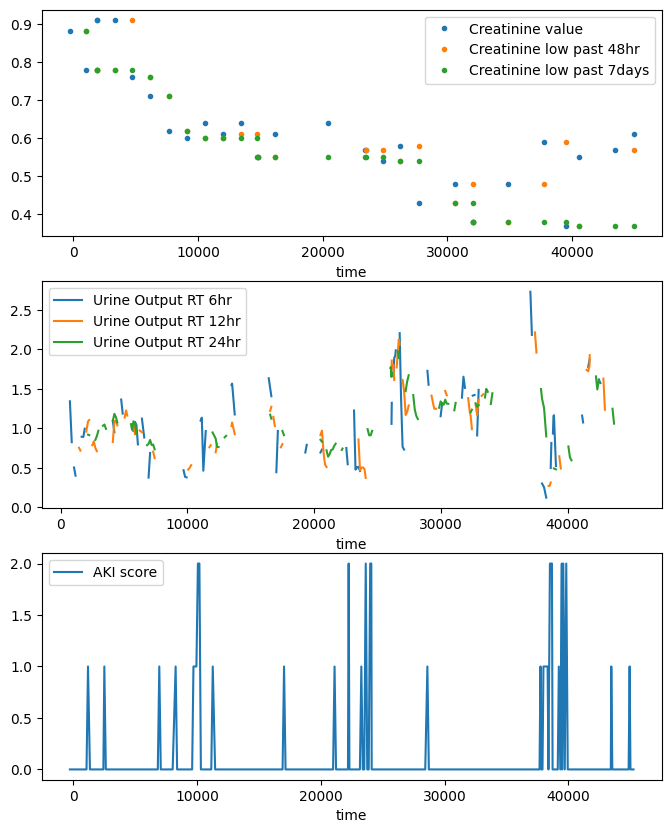

In [93]:
f, axs = plt.subplots(3,1,figsize=(8,10))
pz_tbl = kdigo_stages.query("a_patientid==4016104").sort_values(by='time')

_ = pz_tbl.plot(x='time', y='aki_stage', ax=axs[2], label='AKI score')
_ = pz_tbl.plot(x='time', y='creat', style='.', ax=axs[0], label='Creatinine value')
_ = pz_tbl.plot(x='time', y='creat_48hr', style='.', ax=axs[0], label='Creatinine low past 48hr')
_ = pz_tbl.plot(x='time', y='creat_7days', style='.', ax=axs[0], label='Creatinine low past 7days')
_ = pz_tbl.plot(x='time', y='uo_rt_6hr', ax=axs[1], label='Urine Output RT 6hr')
_ = pz_tbl.plot(x='time', y='uo_rt_12hr', ax=axs[1], label='Urine Output RT 12hr')
_ = pz_tbl.plot(x='time', y='uo_rt_24hr', ax=axs[1], label='Urine Output RT 24hr')
plt.show()